In [ ]:
%pip install pandas matplotlib

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Preprocess

In [2]:
data_path = "public/log(without threadpool).txt"

In [3]:
# Clean the data
## Remove the line until empty line
with open(data_path, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if line == "\n":
            break
    lines = lines[i+1:]

# Number of lines
print("Number of lines: ", len(lines))

Number of lines:  3458


In [10]:
# delimeter each line wioth ':'
data = []
for line in lines:
    data.append(line.split(":"))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["process", "time"])

# Remove the '\n' from the time column
df["time"] = df["time"].str.replace("\n", "")

Analysis

In [11]:
# Display the 'Application run time' and 'Peak memory usage' processes and then remove the row
print("Application run time processes:")
print(df[df["process"].str.contains("Application run time")].to_string(index=False, header=False))
print("\nPeak memory usage processes:")
print(df[df["process"].str.contains("Peak memory usage")].to_string(index=False, header=False))

df = df[~df["process"].str.contains("Application run time")]
df = df[~df["process"].str.contains("Peak memory usage")]

Application run time processes:
Application run time  262.028956056s

Peak memory usage processes:
Peak memory usage  0.6771574 MB of RAM


Length of the memory dataframe:  88
Mean memory:  429.8629481818182
Median memory:  421.52539
Max memory:  591.65137


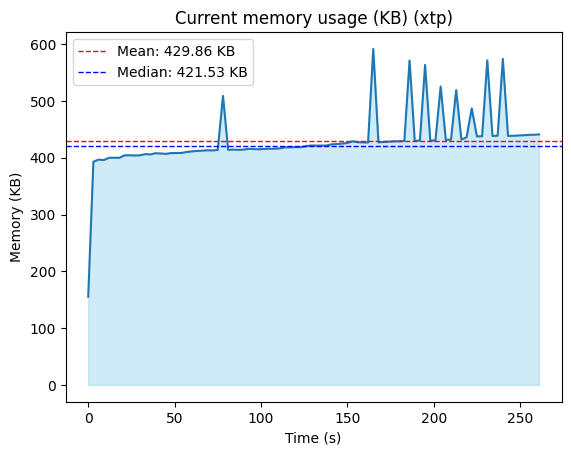

In [12]:
# Plot the 'Current memory usage (KB)' process in a line plot, then remove the rows
    # New dataframe only contains the 'Current memory usage (KB)' process
df_memory = df[df["process"].str.contains("Current memory usage")].copy()
    # Remove the 'Current memory usage (KB)' rows from the original dataframe
df = df[~df["process"].str.contains("Current memory usage")]
    
        # Reset the index
df_memory.reset_index(drop=True, inplace=True)
    # Convert the 'time' column to numeric and change name to 'memory (KB)'
df_memory["memory (KB)"] = pd.to_numeric(df_memory["time"].str.replace(" KB", ""))
    # Remove the 'time' column
df_memory.drop("time", axis=1, inplace=True)

print("Length of the memory dataframe: ", len(df_memory))

# Each record is recorded every 3 seconds
    # Add a new column 'time (s)' to the dataframe by multiplying the index by 3
df_memory["time (s)"] = df_memory.index * 3

# mean, median, max
mean_memory = df_memory["memory (KB)"].mean()
median_memory = df_memory["memory (KB)"].median()
max_memory = df_memory["memory (KB)"].max()
print("Mean memory: ", mean_memory)
print("Median memory: ", median_memory)
print("Max memory: ", max_memory)

# Plot the line plot
plt.plot(df_memory["time (s)"], df_memory["memory (KB)"])
plt.axhline(mean_memory, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_memory:.2f} KB')
plt.axhline(median_memory, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_memory:.2f} KB')
plt.xlabel("Time (s)")
plt.ylabel("Memory (KB)")
plt.title("Current memory usage (KB) (xtp)")
plt.fill_between(df_memory["time (s)"], df_memory["memory (KB)"], color="skyblue", alpha=0.4) # Fill the area under the line graph
plt.legend()
plt.show()

                                   process  count
0       OrderBookManager (Check for trade)    845
1          OrderBookManager (Add to order)    845
2                           OrderConsumer     845
3       MarketDataGenrator (Active Update)    543
4      MarketDataGenrator (Passive Update)    234
5        MarketDataGenrator (Fetch Orders)     51
6  MarketDataGenrator (Sector Performance)      5


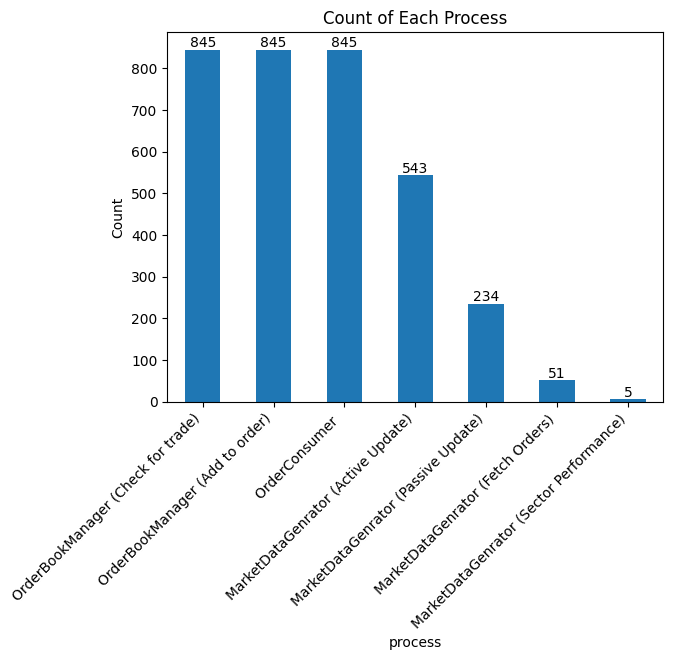

In [13]:
# Number of distinct processes and their count
process_count = df["process"].value_counts()
process_count = process_count.reset_index()
process_count.columns = ["process", "count"]
print(process_count)

ax = process_count.plot(x='process', y='count', kind='bar', legend=False)
plt.ylabel('Count')
plt.title('Count of Each Process')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the count value
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.show()


In [14]:
# Convert the time to ms, mostly are milliseconds, but some are in microseconds
def convert_time(time):
    if "ms" in time:
        return float(time.replace("ms", ""))
    elif "µs" in time:
        return float(time.replace("µs", "")) / 1000
    else:
        return float(time)
    
df["time"] = df["time"].apply(convert_time)

MarketDataGenrator (Passive Update) - Mean: 126.99 ms, Median: 122.16 ms
MarketDataGenrator (Fetch Orders) - Mean: 154.02 ms, Median: 157.07 ms
MarketDataGenrator (Sector Performance) - Mean: 227.60 ms, Median: 260.92 ms
OrderConsumer  - Mean: 0.10 ms, Median: 0.10 ms
OrderBookManager (Add to order) - Mean: 4.42 ms, Median: 4.42 ms
OrderBookManager (Check for trade) - Mean: 7.22 ms, Median: 7.27 ms
MarketDataGenrator (Active Update) - Mean: 5.57 ms, Median: 5.54 ms


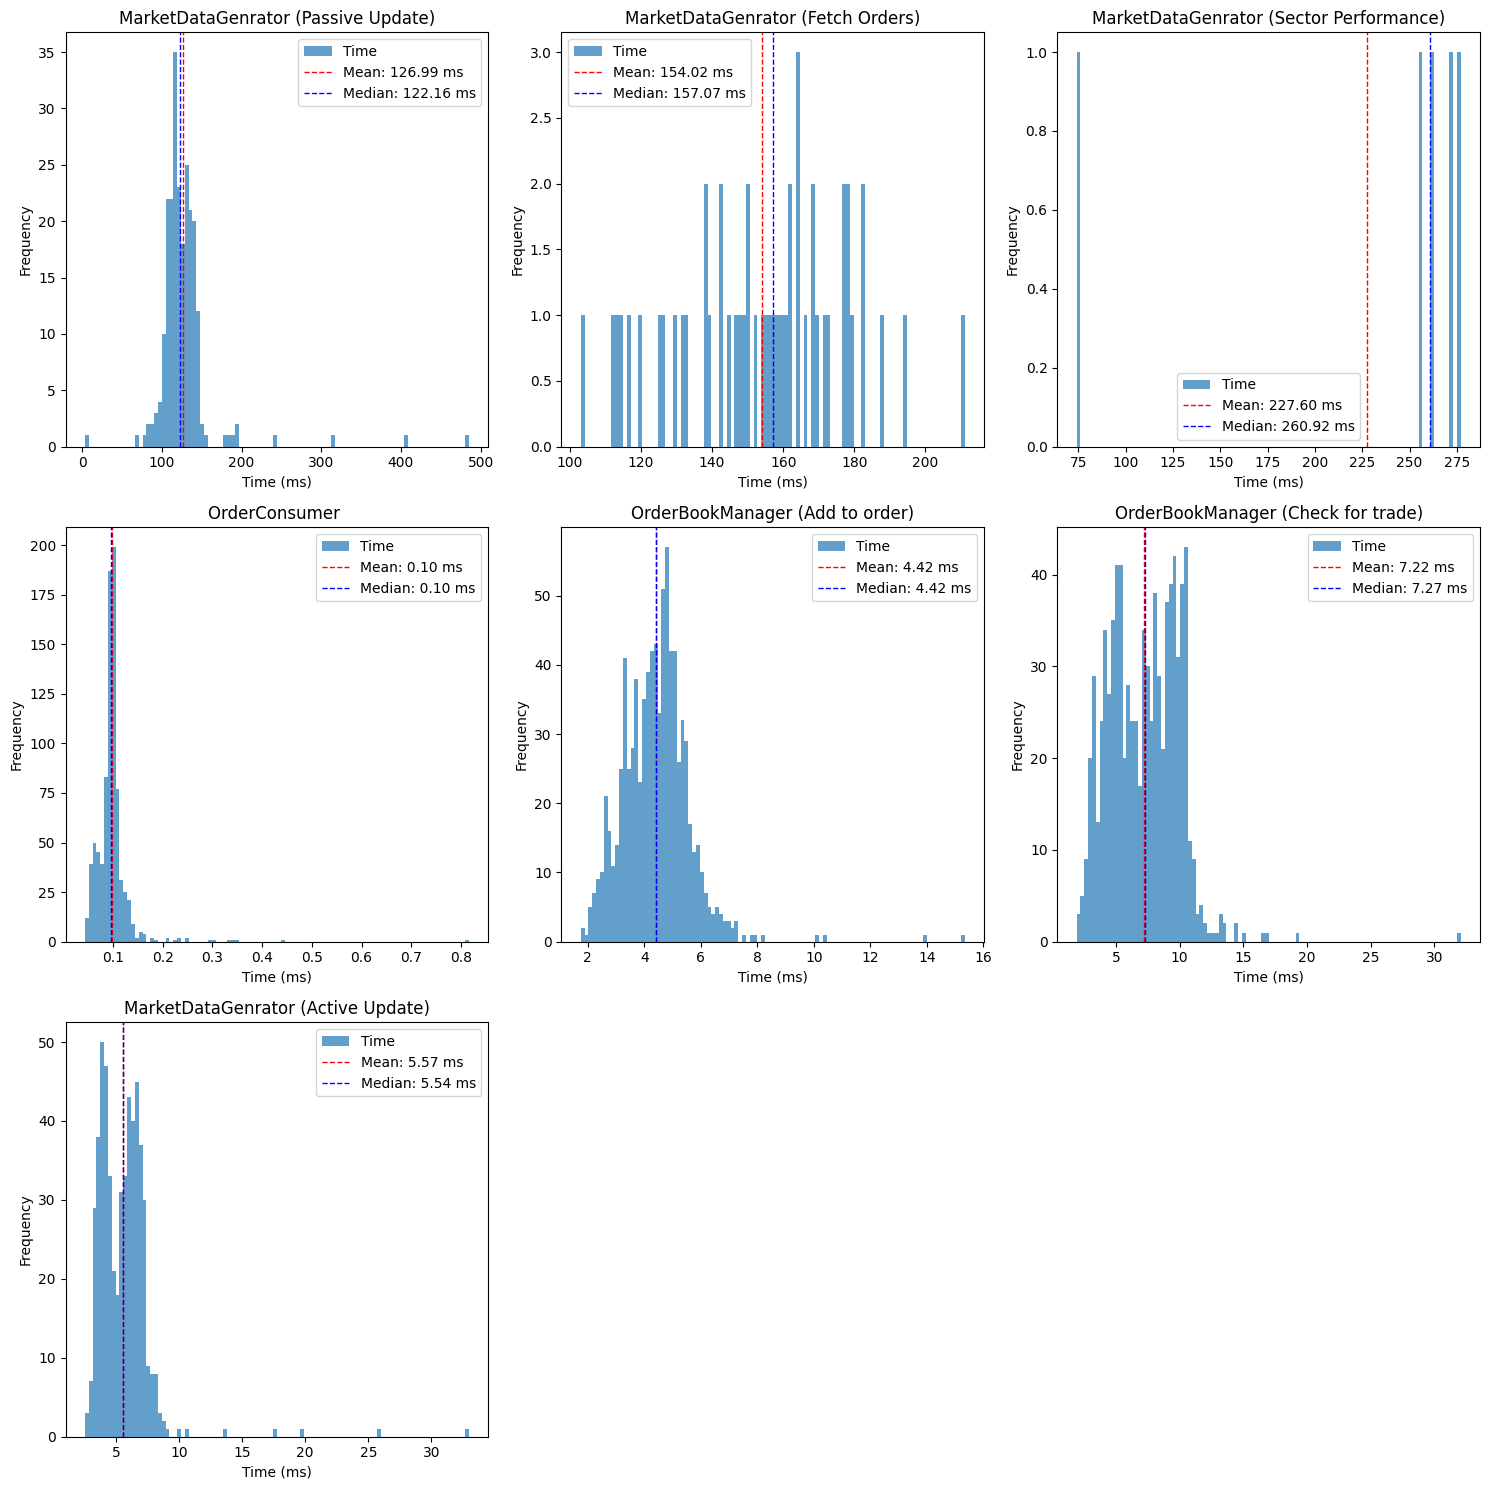

In [15]:
unique_processes = df["process"].unique()
num_processes = len(unique_processes)

# Determine grid size
cols = 3  # Number of columns in the grid
rows = (num_processes + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i, process in enumerate(unique_processes):
    ax = axes[i]
    ax.hist(df[df["process"] == process]["time"], bins=100, alpha=0.7, label='Time')
    mean_time = df[df["process"] == process]["time"].mean()
    median_time = df[df["process"] == process]["time"].median()
    
    ax.axvline(mean_time, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_time:.2f} ms')
    ax.axvline(median_time, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_time:.2f} ms')
    
    ax.set_title(process)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency")
    ax.legend()
    
    print(f"{process} - Mean: {mean_time:.2f} ms, Median: {median_time:.2f} ms")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

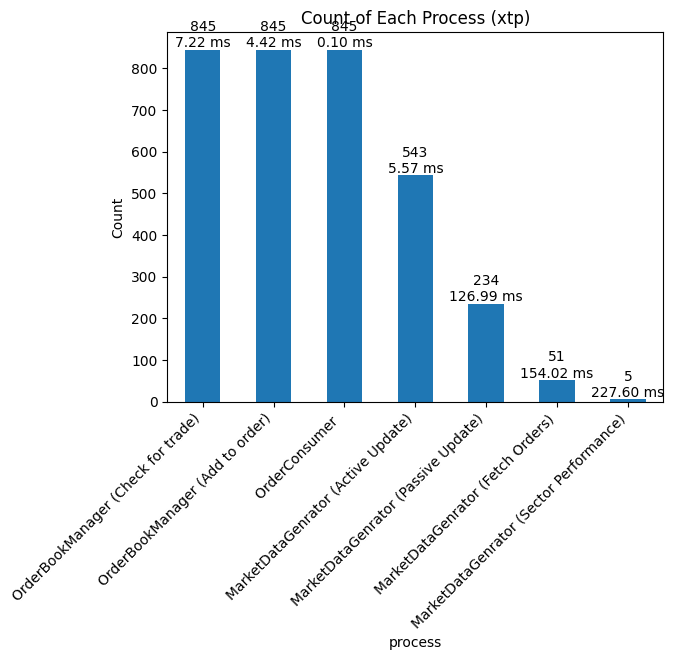

In [17]:
# Number of distinct processes and their count
process_count = df["process"].value_counts()
process_count = process_count.reset_index()
process_count.columns = ["process", "count"]

# Calculate mean time for each process
mean_times = df.groupby("process")["time"].mean().reset_index()
mean_times.columns = ["process", "mean_time"]

# Merge mean times with process count
process_count = process_count.merge(mean_times, on="process")

# Plot the bar chart
ax = process_count.plot(x='process', y='count', kind='bar', legend=False)
plt.ylabel('Count')
plt.title('Count of Each Process (xtp)')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the count value and mean time
for container in ax.containers:
    ax.bar_label(container, labels=[f'{count}\n{mean_time:.2f} ms' for count, mean_time in zip(process_count['count'], process_count['mean_time'])], label_type='edge')

plt.show()


Passive Update Comparison - ThreadPool vs No ThreaPool

In [ ]:
no_threadpool_data_path = "public/log(without threadpool).txt"

In [ ]:
# Same as above, preprocess the data
with open(no_threadpool_data_path, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if line == "\n":
            break
    lines = lines[i+1:]

data = []
for line in lines:
    data.append(line.split(":"))

xtp_df = pd.DataFrame(data, columns=["process", "time"])

# Make a new df with only the processes of 'MarketDataGenrator (Passive Update)'
xtp_df = xtp_df[xtp_df["process"] == "MarketDataGenrator (Passive Update)"]
    # length of the df
print("Number of lines: ", len(xtp_df))

xtp_df["time"] = xtp_df["time"].str.replace("\n", "")

# Remove the 

In [ ]:
# Filter the original df with the processes of 'MarketDataGenrator (Passive Update)' and also only the first len(xtp_df) rows
tp_df = df[df["process"] == "MarketDataGenrator (Passive Update)"][:len(xtp_df)]

In [ ]:
# Plot the graph for the time taken for each process
plt.hist(tp_df["time"], bins=100, alpha=0.7, label='With Threadpool')
plt.hist(xtp_df["time"], bins=100, alpha=0.7, label='Without Threadpool')

# Calculate mean times
mean_time_with_threadpool = tp_df["time"].mean()
mean_time_without_threadpool = xtp_df["time"].mean()

# Plot mean times
plt.axvline(mean_time_with_threadpool, color='red', linestyle='dashed', linewidth=1, label=f'Mean With Threadpool: {mean_time_with_threadpool:.2f} ms')
plt.axvline(mean_time_without_threadpool, color='blue', linestyle='dashed', linewidth=1, label=f'Mean Without Threadpool: {mean_time_without_threadpool:.2f} ms')

plt.title("Time taken for MarketDataGenrator (Passive Update)")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.legend()
plt.show()